In [349]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import cv2
import pickle
import matplotlib.image as mpimg
import lane_detect as l # from project 4
import time
from skimage.feature import hog
import glob
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label


%matplotlib inline

In [350]:
# from IPython.display import HTML
# from moviepy.editor import VideoFileClip

# video_output = 'project_video_output.mp4'
# video_input = VideoFileClip('project_video.mp4')#.subclip(20,32)#.subclip(10,12)
# #video_input.save_frame("start.jpg", t=12) # saves the frame at time 

# processed_video = video_input.fl_image(l.video_pipeline)
# processed_video.write_videofile(video_output, audio=False)
# %time processed_video.write_videofile(video_output, audio=False)

## Lesson functions

In [351]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys', transform_sqrt=True,
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
#         image = cv2.imread(file)
#         cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    


## Experimentation with different Parameters

In [352]:
# loading data set
notcar_img_names = glob.glob('data/non-vehicles/**/*.png')
car_img_names = glob.glob('data/vehicles/**/*.png')
print("Data set size: %d cars, %d not-cars"%(len(car_img_names), len(notcar_img_names)))


# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time

# sample_size = 3000
# car_img_names = car_img_names[0:sample_size]
# notcar_img_names = notcar_img_names[0:sample_size]

spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


# ##### test 1: 0.9544
# color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 12  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# ##### test 2: 0.9769
# color_space = 'HLS'  
# orient = 9   
# pix_per_cell = 8  
# cell_per_block = 2 
# hog_channel = "ALL" 

# ##### test 3: 0.978
# color_space = 'HLS'  
# orient = 12  
# pix_per_cell = 16  
# cell_per_block = 2  
# hog_channel = "ALL"  
# #########

##### test 4: 0.9859
color_space = 'YCrCb'  
orient = 12 
pix_per_cell = 16 
cell_per_block = 2  
hog_channel = "ALL"  
#########

# ##### test 5: 0.9803
# color_space = 'YCrCb'  
# orient = 12 
# pix_per_cell = 8  
# cell_per_block = 2  
# hog_channel = "ALL" 
# #########

# ##### test 6: 0.9828
# color_space = 'YCrCb' 
# orient = 9 
# pix_per_cell = 8 
# cell_per_block = 2  
# hog_channel = "ALL" 
# #########

# ##### test 7: 0.9811
# color_space = 'YCrCb'  
# orient = 12 
# pix_per_cell = 16 
# cell_per_block = 4 
# hog_channel = "ALL"  
# #########


t=time.time()

car_features = extract_features(car_img_names, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcar_img_names, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract features...')

Data set size: 8792 cars, 9085 not-cars
52.76 Seconds to extract features...


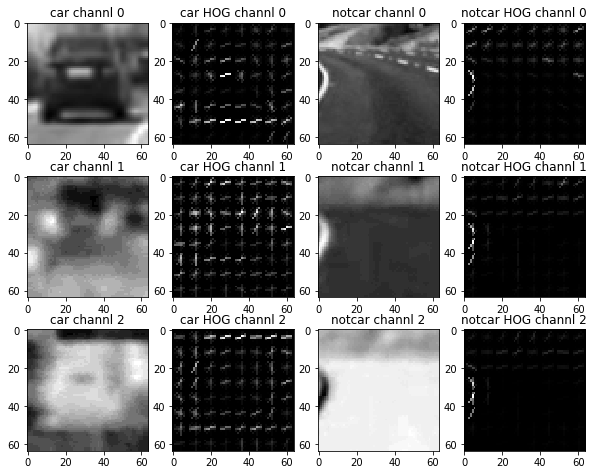

In [353]:
# visiualize data
f, axes = plt.subplots(3, 4, figsize=(10,8))
features = extract_features(car_img_names[0:2], color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
# features = np.array(features)
# print("features max/min", np.max(features[0]),np.min(features[0]))
# scaled = X_scaler.transform(features)
# print("scaled max/min", np.max(scaled[0]),np.min(scaled[0]))

for channel in [0,1,2]:
    car_img = cv2.imread(car_img_names[0])
    car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)

    # car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)[:,:,channel]
    # car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2LUV)[:,:,channel]
    car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YUV)[:,:,channel]

    notcar_img = cv2.imread(notcar_img_names[4])
    notcar_img = cv2.cvtColor(notcar_img, cv2.COLOR_BGR2RGB)
    # notcar_img = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2YCrCb)[:,:,channel]
    # notcar_img = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2LUV)[:,:,channel]
    notcar_img = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2YUV)[:,:,channel]


    _, car_hog_img = get_hog_features(car_img, orient=9, pix_per_cell=8, cell_per_block=2, vis = True, feature_vec=True)
    _, notcar_hog_img = get_hog_features(notcar_img, orient=9, pix_per_cell=8, cell_per_block=2, vis = True)

    axes[channel, 0].imshow(car_img,cmap='gray')
    axes[channel, 0].set_title('car channl %d'%channel)
    axes[channel, 1].imshow(car_hog_img,cmap='gray')
    axes[channel, 1].set_title('car HOG channl %d'%channel)

    axes[channel, 2].imshow(notcar_img,cmap='gray')
    axes[channel, 2].set_title('notcar channl %d'%channel)
    axes[channel, 3].imshow(notcar_hog_img,cmap='gray')
    axes[channel, 3].set_title('notcar HOG channl %d'%channel)
                     

# Training Classifier

In [354]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
print("# training ", len(y_train), " # test ", len(y_test))
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# training  14301  # test  3576
Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2112
7.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9787
My SVC predicts:  [ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.]
0.00188 Seconds to predict 10 labels with SVC


## Search & predict

In [355]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
    #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
#     print(color_space, spatial_size, hist_bins)

    return np.concatenate(img_features)


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6, copy=True, alpha = .5):
    # Make a copy of the image
    if copy:
        imcopy = np.copy(img)
    else:
        imcopy = img
        
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return cv2.addWeighted(img, alpha, imcopy, 1 - alpha, 0, img)
    #return imcopy


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    img = img.astype(np.float32)/255

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#         print("max feature", np.max(test_features))
#         print(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows




### Multi Level windows (slow code)


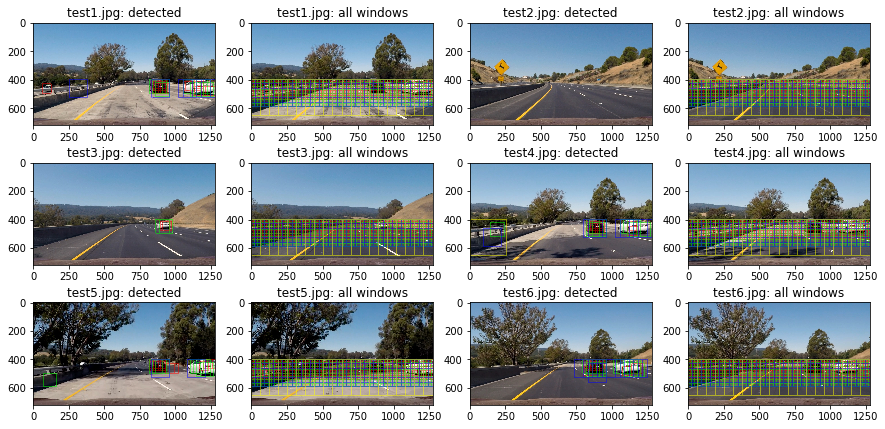

In [390]:
def multi_level_windows(img, ret_all_windows=False):
#     level0 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400,470], 
#                     xy_window=(32, 32), xy_overlap=(0.75, 0.75))
    level1 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400,550], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)) 
    level2 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400,600], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    level3 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400,600], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    level4 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400,700], 
                    xy_window=(256, 256), xy_overlap=(0.75, 0.75))
    
    levels = [level1, level2, level3, level4]
    hot = []
    for l in levels:
        hot_windows = search_windows(img, l, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
        hot.append(hot_windows)
    
    if ret_all_windows:
        return hot, levels
    return  hot


img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img1= np.copy(img)
img2= np.copy(img)

hot, levels = multi_level_windows(img, ret_all_windows=True)                       
colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]

for i in range(len(levels)):
    window_img = draw_boxes(img1, hot[i], color=colors[i], thick=6, alpha=.5)                    
    all_windows = draw_boxes(img2, levels[i], color=colors[i], thick=6, alpha=.5)


f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 7))
ax1.imshow(window_img)
ax1.set_title("Detected cars")
ax2.imshow(all_windows)
ax2.set_title("All windows")

images = np.sort(glob.glob('./test_images/*.jpg'))
                 
plt.clf()
fig = plt.figure(figsize=(15,15))

counter = 1
for img_name in images:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1= np.copy(img)
    img2= np.copy(img)

    hot, levels = multi_level_windows(img, ret_all_windows=True)                       
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]                     

    for i in range(len(levels)):
        window_img = draw_boxes(img1, hot[i], color=colors[i], thick=6, alpha=.5)                    
        all_windows = draw_boxes(img2, levels[i], color=colors[i], thick=6, alpha=.5)

    # Display the final results
    fig.add_subplot(len(images), 4, counter)
    plt.title(img_name.split('/')[-1]+": detected")
    plt.imshow(window_img)
    counter += 1

    fig.add_subplot(len(images), 4, counter)
    plt.title(img_name.split('/')[-1]+": all windows")
    plt.imshow(all_windows)
    counter += 1

### Multi-Level Fast

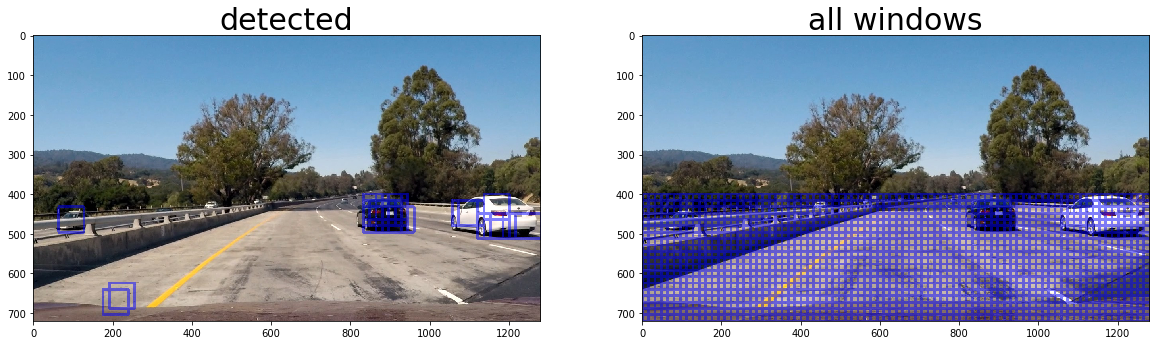

In [357]:
#################################################################################
###################### TODO NOT USED IN THIS IMPLEMENTATION #####################
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, scale, svc, X_scaler, y_start_stop=[400,700],x_start_stop=[None,None], orient=9, pix_per_cell=8,\
              cell_per_block=2, spatial_size=(32, 32), hist_bins=32,color_space='RGB', cells_per_step = 2,\
              hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True, vis=False, ret_all_windows=False):

    if vis:
        draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #img = img.astype("float")
    y_start = y_start_stop[0]

    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],x_start_stop[0]:x_start_stop[1]]
    
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
  
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
 

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_boxes = []
    all_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1
            
#             if not only_hog:
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(test_features.reshape(1,-1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))   
#             print("max feature", np.max(test_features))
            test_prediction = svc.predict(test_features)
        
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            box = [(xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])]
            
            if ret_all_windows:
                all_boxes.append(box)
                
            if test_prediction == 1:

                if vis:
                    cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
                hot_boxes.append(box)
    if vis:
        return draw_img
    else:
        if ret_all_windows:
            return hot_boxes, all_boxes
        return hot_boxes
 
    
# img = cv2.imread("data/vehicles/GTI_MiddleClose/image0297.png")
img = cv2.imread("test_images/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img1 = np.copy(img)
img2 = np.copy(img)
scale = 1
y_start_stop = [400, img.shape[0]]
x_start_stop = [None, None]

# out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
hot_boxes, all_boxes = find_cars(img, scale, svc, X_scaler, y_start_stop=y_start_stop, x_start_stop=x_start_stop,color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, cells_per_step = 1,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, ret_all_windows=True) 

window_img = draw_boxes(img1, hot_boxes,   thick=6, alpha=.5)
all_window_img = draw_boxes(img2, all_boxes, thick=6, alpha=.5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(window_img)
ax1.set_title('detected', fontsize=30)
ax2.imshow(all_window_img)
ax2.set_title('all windows', fontsize=30)


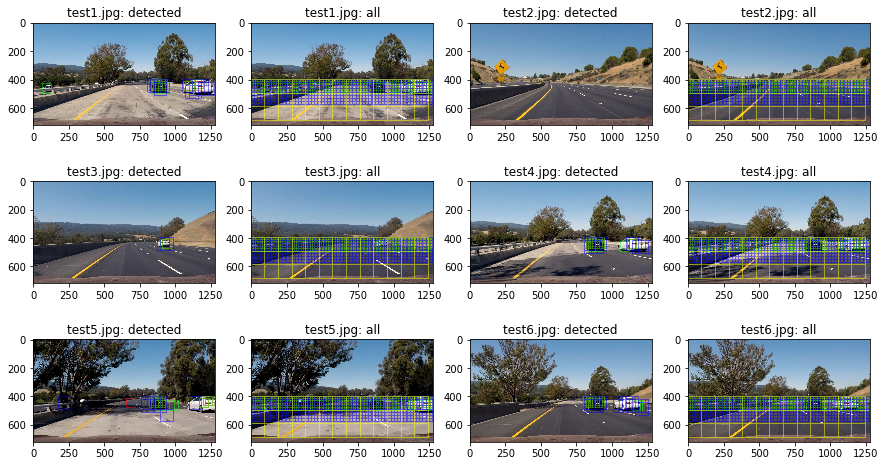

In [454]:
def multi_level_windows_fast(img, ret_all_windows=False):
    
#     y_starts = [380, 400, 410]
    y_starts = [400,400, 400, 400]
    y_stops =  [480,500, 600, 700]
    
    scales = [1,1,1.4,3]
    cell_steps = [1,1,1,2]
    hot = []
    all_b = []
    for i in range(len(scales)):
        h = find_cars(img, scales[i], svc, X_scaler, y_start_stop=[y_starts[i],y_stops[i]], x_start_stop=x_start_stop,\
                    color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, cells_per_step = cell_steps[i],
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat, ret_all_windows= ret_all_windows)
        if ret_all_windows:
            hot.append(h[0])
            all_b.append(h[1])
        else:
            hot.append(h)

    if ret_all_windows:
        return hot, all_b
    else:
        return hot




images = np.sort(glob.glob('./test_images/*.jpg'))
                 
plt.clf()
fig = plt.figure(figsize=(15,17))

counter = 1
for img_name in images:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1= np.copy(img)
    img2= np.copy(img)

    hot,all_b = multi_level_windows_fast(img, ret_all_windows=True) 
    colors = [(255,0,0), (0,255,0), (0,0,255),(255,255,0)]
    for i in range(len(hot)):
        window_img = draw_boxes(img1, hot[i], color=colors[i], thick=6, alpha=.5)
        all_window_img = draw_boxes(img2, all_b[i], color=colors[i], thick=6, alpha=.5)

    # Display the final results
    fig.add_subplot(len(images), 4, counter)
    plt.title(img_name.split('/')[-1]+": detected")
    plt.imshow(window_img)
    counter += 1
    
    fig.add_subplot(len(images), 4, counter)
    plt.title(img_name.split('/')[-1]+": all")
    plt.imshow(all_window_img)
    counter += 1


### False Positives

[[(806, 400), (895, 489)], [(806, 422), (895, 511)], [(828, 400), (917, 489)], [(828, 422), (917, 511)], [(851, 400), (940, 489)], [(851, 422), (940, 511)], [(873, 400), (962, 489)], [(1007, 400), (1096, 489)], [(1007, 422), (1096, 511)], [(1052, 400), (1141, 489)], [(1052, 422), (1141, 511)], [(1075, 400), (1164, 489)], [(1075, 422), (1164, 511)], [(1097, 400), (1186, 489)], [(1097, 422), (1186, 511)], [(1120, 422), (1209, 511)], [(1142, 422), (1231, 511)], [(1164, 422), (1253, 511)], [(1164, 444), (1253, 533)]]
[(336, 506), (528, 698)]


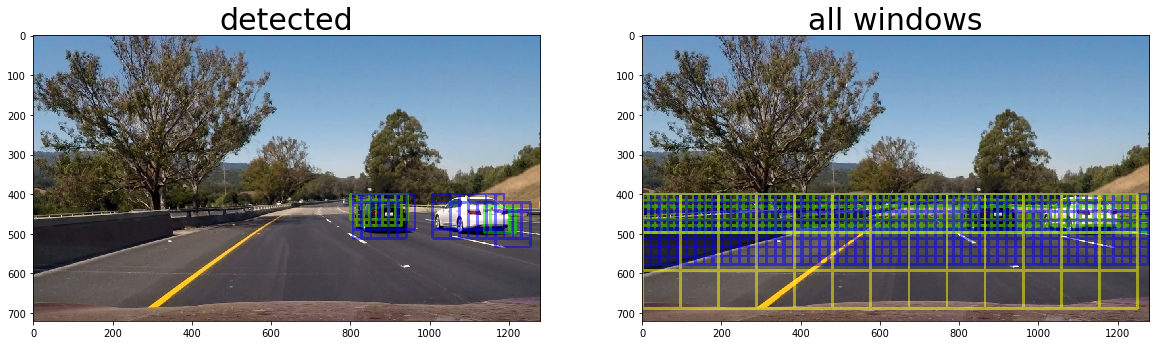

In [456]:
img = cv2.imread("test_images/test6.jpg")
#img = cv2.imread("video-snapshots/video_t=27.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img1= np.copy(img)
img2= np.copy(img)

hot,all_b = multi_level_windows_fast(img, ret_all_windows=True) 
print(hot[2])
# box = hot[2][0]
print(box)
colors = [(255,0,0), (0,255,0), (0,0,255),(255,255,0)]
for i in range(len(hot)):
    window_img = draw_boxes(img1, hot[i], color=colors[i], thick=6, alpha=.5)
    all_window_img = draw_boxes(img2, all_b[i], color=colors[i], thick=6, alpha=.5)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(window_img)
ax1.set_title('detected', fontsize=30)
ax2.imshow(all_window_img)
ax2.set_title('all windows', fontsize=30)




True

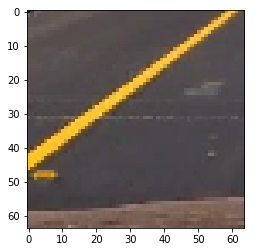

In [379]:

false_pos = cv2.resize(img[box[0][1]:box[1][1],box[0][0]:box[1][0]], (64,64))
plt.imshow(false_pos)

name = 'data/non-vehicles/false-positives/false-positive118.png'
false_pos=cv2.cvtColor(false_pos, cv2.COLOR_RGB2BGR)
cv2.imwrite(name,false_pos)


## Heatmap

1.0


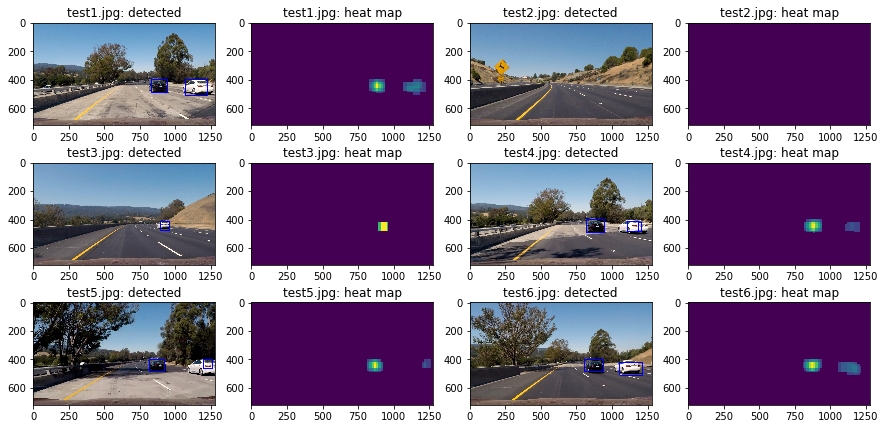

In [522]:


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for l in range(len(bbox_list)):
        for box in bbox_list[l]:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2)) 
            inc = 1             
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += inc

    # Return updated heatmap
    return heatmap# 
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, bboxes):
    # Iterate through all detected cars
    boxes = []
    for bbox in bboxes:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

def get_bboxes(img, labels):
    # Iterate through all detected cars
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
  
    return bboxes

# threshold1 sets the minimum bbox area in the area between y=700 to y = 500
# threshold2 drops very small boxes for all the images
def area_threshold(bboxes, threshold1 = 110*110, threshold2=30*30, y_start_stop = [500,700]):
    good_bboxes = []
    for bbox in bboxes:
        b_min, b_max = bbox[0],bbox[1]
        area = np.abs((b_min[0] - b_max[0]) * (b_min[1] - b_max[1]))
        if b_max[1] >= y_start_stop[0] and b_min[1] <= y_start_stop[1]:
            if area >= threshold1:
                good_bboxes.append(bbox)
        elif area >= threshold2:
            good_bboxes.append(bbox)
    return good_bboxes


#returns bboxes that have height/width <= threshold
def shape_threshold(bboxes, threshold = .7, y_start_stop = [500,700]):
    good_bboxes = []
    for bbox in bboxes:
        b_min, b_max = bbox[0],bbox[1]
        height = -b_min[1] + b_max[1]
        width = -b_min[0] + b_max[0]
        ratio = height/width
        if ratio  <= threshold:
             good_bboxes.append(bbox)
    return good_bboxes
    
box1 = [[0,0],[10,100]]
box2 = [[0,0], [200,200]]
shape_threshold([box1,box2])

#########################
######## NOT USED #######
def get_overlap_ratio(box1, box2):
    a_min, a_max = box1[0],box1[1]
    b_min, b_max = box2[0],box2[1]
    
    area_a = np.abs((a_min[0] - a_max[0]) * (a_min[1] - a_max[1]))
    area_b = np.abs((b_min[0] - b_max[0]) * (b_min[1] - b_max[1]))
    
    if _overlapping(box1,box2):
        A = np.abs(b_min[1] - a_max[1])
        B = np.abs(b_min[0] - a_max[0])
        area = np.abs(A*B)
        return np.max((area/area_a, area/area_b))
    return 0

def _overlapping(box1, box2):  
    a_min, a_max = box1[0],box1[1]
    b_min, b_max = box2[0],box2[1]
    overlapping = True
    if (a_min > b_max) or (a_max < b_min):
        overlapping = False
    return overlapping

box1 = [[0,0],[100,100]]
box2 = [[0,0], [200,200]]
r = get_overlap_ratio(box1,box2)
print(r)
#########################
#########################

images = np.sort(glob.glob('./test_images/*.jpg'))
                 
plt.clf()
fig = plt.figure(figsize=(15,15))

counter = 1
for img_name in images:
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box_list = multi_level_windows_fast(img)

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bboxes = get_bboxes(img,labels)
    bboxes = area_threshold(bboxes)
    draw_img = draw_labeled_bboxes(np.copy(img), bboxes)


    # Display the final results
    fig.add_subplot(len(images), 4, counter)
    plt.title(img_name.split('/')[-1]+": detected")
    plt.imshow(draw_img)
    counter += 1
    

    fig.add_subplot(len(images), 4, counter)
    plt.title(img_name.split('/')[-1]+": heat map")
    plt.imshow(heatmap)
    counter += 1
   

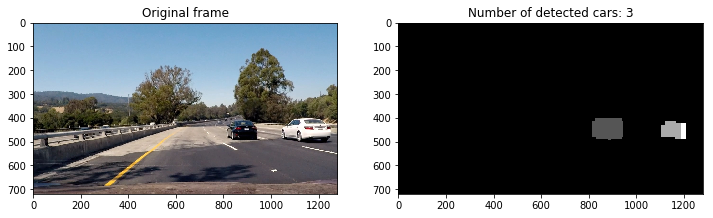

In [458]:
img = cv2.imread("test_images/test4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
box_list = multi_level_windows_fast(img)

heat = np.zeros_like(img[:,:,0]).astype(np.float)

heat = add_heat(heat,box_list)

heat = apply_threshold(heat,3)

heatmap = np.clip(heat, 0, 255)

labels = label(heatmap)

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 7))
ax1.imshow(img)
ax1.set_title("Original frame")
ax2.imshow(labels[0], cmap='gray')
ax2.set_title("Number of detected cars: %d"% labels[1])
plt.show()

In [550]:
frame_count = 0
heat_list = []
bboxes = []
queue_length = 8

skip_every = 5
def detect_pipeline(img):
    global frame_count, skip_every, bboxes, heat_list
    frame_count += 1

    if frame_count >= queue_length and frame_count % skip_every == 0:
        box_list = multi_level_windows_fast(img) 
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
        heat_list.append(heat)
        if len(heat_list) >= queue_length:
            heat_list = heat_list[len(heat_list)-queue_length:]
        total_heat = np.sum(heat_list, axis = 0)
        # Apply threshold to help remove false positives
        heat = apply_threshold(total_heat,3.1 *queue_length+0)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        bboxes = get_bboxes(img,labels)
        bboxes = area_threshold(bboxes, threshold1 = 110*110, threshold2=30*30, y_start_stop = [500,700])
        bboxes = shape_threshold(bboxes, threshold=1.4)
        
    draw_img = draw_labeled_bboxes(np.copy(img), bboxes)
    return draw_img




In [551]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip
heat_list = []
bboxes = []

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')#.subclip(25,35)
# video_input = VideoFileClip('project_video.mp4')#.subclip(25,40)

video_input.save_frame("video-snapshots/video_t=27.jpg", t=27) # saves the frame at time 

processed_video = video_input.fl_image(detect_pipeline)
%time processed_video.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:20<00:00,  8.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 7s, sys: 1.93 s, total: 4min 9s
Wall time: 2min 21s
